In [48]:
import pandas as pd
import re
import contractions
import string
import seaborn as sns 


In [49]:
df = pd.read_csv('video_info.csv')

# Data Cleaning

## Get Monetary Values
Easy to hard to get:
1. $xxx,xxx,xxx in the title - DONE
2. $xx million in the title - DONE
3. _______ Price: $ xxx,xxx,xxx in the description
4. Not listed

In [50]:

def extract_clear_dollar_amount(title):
    full_dollar_pattern = r'\$(\d{1,3}(,\d{3})*)'
    match = re.search(full_dollar_pattern, title)
    if match:
        value = int(match.group(1).replace(',', ''))
        if value > 1000:
            return value
    return None

def extract_dollar_amount(title):
    partial_dollar_pattern = r'\$(\d{1,3}(?:,\d{3})*(?:\.\d+)?)'
    match = re.search(partial_dollar_pattern, title)
    if match:
        # Remove commas and convert to float, then scale to integer
        value = float(match.group(1).replace(',', ''))
        return (value * 1_000_000) if 'Million' in title else None
    return None

def extract_dollar_description(description):
    for line in description.splitlines():
        if "Price:" in line:
            match = re.search(r'\$(\d{1,3}(,\d{3})*)', line)
            if match:
                dollar_amount = int(match.group(1).replace(',', ''))
                return dollar_amount
    return None

def dollar_amount(row):
    # Try to extract clear dollar amount from title
    clear_amount = extract_clear_dollar_amount(row['title'])
    if clear_amount is not None:
        return clear_amount
    
    # Try to extract dollar amount with "Million" from title
    title_amount = extract_dollar_amount(row['title'])
    if title_amount is not None:
        return title_amount
    
    # Try to extract dollar amount from description
    description_amount = extract_dollar_description(row['description'])
    if description_amount is not None:
        return description_amount
    
    return None

df['dollar_amount'] = df.apply(dollar_amount, axis=1)

In [51]:
# doing the rest by hand, filling in assets without prices or prices only in thumbnail because property is sold
manual_df = pd.read_csv("manual_dollar_amounts.csv")

# combine auto dollar values with manual dollar values
df['dollar_amount'] = df.merge(
    manual_df,
    on='id',
    how='left'
)['value'].fillna(df['dollar_amount'])

# drop values without dollar amounts 
df = df[~df['dollar_amount'].isna()]
df.shape

(239, 5)

## Text Cleaning

In [76]:
def remove_bracketed_text(text):
    text_in_brackets = r'\[.*?\]'
    text = re.sub(text_in_brackets, '', text)
    return text

def remove_empty_lines(text):
    """Remove multiple consecutive empty lines"""
    text = re.sub(r'\n\s*\n', '\n', text)
    return text

def remove_markers(text):
    """Remove speaker indicators like "-" at start of sentences"""
    speaker_markers = r'\s*-\s+'
    text = re.sub(speaker_markers, '', text, flags=re.MULTILINE)
    return text

def remove_filler(text):
    # Remove filler words
    filler_words = r'\b(um|uh|like|you know)\b'
    text = re.sub(filler_words, '', text, flags=re.IGNORECASE)
    return text

def expand_contraction(text):
    words = text.split()
    expanded_words = [contractions.fix(word) for word in words]
    expanded_text = ' '.join(expanded_words)
    return expanded_text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def clean_script(text) -> str:
    text = text.lower()
    text = text.strip()
    text = ' '.join(text.split())
    
    text = remove_bracketed_text(text)
    text = remove_markers(text)
    text = remove_empty_lines(text)
    text = remove_filler(text)
    text = remove_punctuation(text)
    text = expand_contraction(text)
    
    
    return text
    
df['script'] = df['script'].apply(clean_script)

In [77]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    
    tokens = nltk.word_tokenize(text)
    
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    
    return " ".join(lemmatized)

# Apply to dataframe
df['script'] = df['script'].apply(lemmatize)


In [78]:
# remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stop_words(text) -> str:
    words = text.split()
    
    # Filter out stop words
    edited_text = [word for word in words if word.lower() not in stop_words]
    
    # Join the words back into a single string
    text_no_stop = " ".join(edited_text)
    return text_no_stop

df['script'] = df['script'].apply(remove_stop_words)

# Analysis

In [79]:
df['word_count'] = df['script'].apply(lambda x: len(x.split()))

## Clustering

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import BisectingKMeans

# Create vectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['script'])

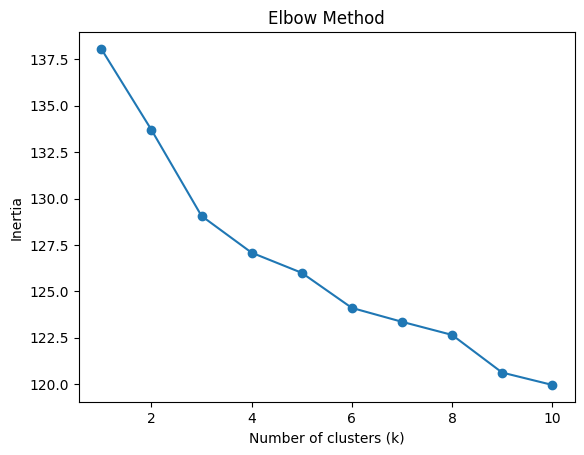

In [142]:
import matplotlib.pyplot as plt

# elbow method
inertias = []
K = range(1, 11)

for k in K:
    kmeans = BisectingKMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors)
    inertias.append(kmeans.inertia_)
    
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [143]:

# Perform clustering
kmeans = BisectingKMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(vectors)

df['clusters'] = clusters

In [144]:
df[['clusters','title']].to_clipboard()

In [145]:
from collections import Counter

for cluster_number in range(3):
    cluster_data = df[df['clusters'] == cluster_number]
    script = " ".join( [word for word in cluster_data['script']] )
    print(Counter(script.split()))

Counter({'go': 721, 'yacht': 487, 'get': 459, 'look': 430, 'want': 387, 'see': 371, 'door': 362, 'one': 347, 'area': 338, 'space': 331, 'tour': 320, 'detail': 290, 'come': 283, 'light': 281, 'actually': 272, 'way': 272, 'two': 265, 'seat': 257, 'beautiful': 241, 'back': 234, 'another': 232, 'take': 230, 'deck': 230, 'well': 218, 'open': 211, 'also': 200, 'bathroom': 188, 'nice': 177, 'make': 176, 'vessel': 176, 'around': 172, 'little': 168, 'level': 168, 'love': 165, 'incredible': 160, 'window': 159, 'design': 158, 'wall': 157, 'first': 156, 'kind': 155, 'check': 150, 'floor': 148, 'bit': 148, 'builtin': 148, 'mean': 147, 'bed': 144, 'feel': 143, 'enjoy': 143, 'continue': 138, 'cool': 137, 'guest': 134, 'opening': 132, 'tv': 132, 'table': 128, 'talk': 127, 'center': 126, 'water': 126, 'super': 125, 'everything': 122, 'throughout': 120, 'glass': 118, 'say': 116, 'owner': 114, 'much': 114, 'panel': 113, 'amaze': 113, 'marble': 113, 'main': 111, 'lead': 110, 'give': 109, 'section': 108, '

### DBSCAN

In [135]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Vectorize the text
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(df['script'])

# Apply NMF clustering
n_components = 2  # Adjust this based on desired number of clusters
nmf = NMF(n_components=n_components, random_state=42)
W = nmf.fit_transform(X)

# Assign clusters based on highest weight
df['clusters'] = np.argmax(W, axis=1)

# Copy results to clipboard
df[['clusters','title']].to_clipboard()


## Sentiment

In [14]:
from textblob import TextBlob

# simple full script polarity
df['sentiment_polarity'] = df['script'].apply(lambda x: TextBlob(x).sentiment.polarity)

## Named Entity Recognition (Location)

In [16]:
import spacy

nlp = spacy.load('en_core_web_sm')

def extract_locations(text):
    doc = nlp(text)
    locations = [entity.text for entity in doc.ents if entity.label_ == 'GPE']
    return locations

df['locations'] = df['script'].apply(extract_locations)

In [17]:
from itertools import chain
from collections import Counter
unique_values = Counter(chain.from_iterable(df['locations']))
unique_values

Counter({'los angeles': 273,
         'california': 136,
         'dubai': 74,
         'florida': 55,
         'new york city': 50,
         'new york': 47,
         'texas': 43,
         'italy': 27,
         'france': 27,
         'santa monica': 26,
         'utah': 22,
         'chicago': 21,
         'manhattan': 21,
         'colorado': 21,
         'hardwood': 20,
         'saota': 19,
         'beverly hill': 15,
         'paris': 15,
         'newport beach': 15,
         'jordan': 15,
         'juliet balcony': 13,
         'shou': 13,
         'london': 12,
         'south africa': 12,
         'miami': 12,
         'west hollywood': 12,
         'la jolla': 11,
         'monaco': 10,
         'park city': 10,
         'germany': 9,
         'manhattan beach': 9,
         'miami beach': 8,
         'san fernando valley': 8,
         'san francisco': 8,
         'san fernando': 7,
         'india': 6,
         'turkey': 6,
         'la': 6,
         'new jersey': 6,
        

In [18]:
df['flag_california'] = df['script'].str.contains('california', case=False, na=False).astype(int)
df['flag_beach'] = df['script'].str.contains('beach', case=False, na=False).astype(int)
df['flag_dubai'] = df['script'].str.contains('dubai', case=False, na=False).astype(int)
df['flag_florida'] = df['script'].str.contains('florida', case=False, na=False).astype(int)
df['flag_texas'] = df['script'].str.contains('texas', case=False, na=False).astype(int)
df['flag_la'] = df['script'].str.contains('los angeles', case=False, na=False).astype(int)


## Unique Words|

<Axes: xlabel='unique_words', ylabel='dollar_amount'>

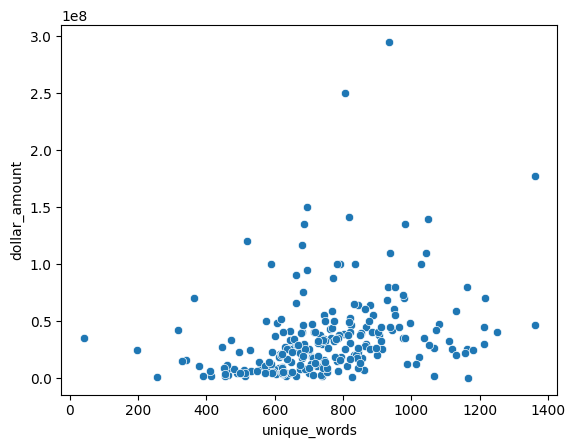

In [19]:
df['unique_words'] = df['script'].apply(lambda x: len(set(x.split())))

sns.scatterplot(df, x='unique_words',y='dollar_amount')

## TF-IDF Modeling

### Simple Linear Regression

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error


vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['script'])

X_dense = X.toarray() 
word_count_array = df[['word_count', 'sentiment_polarity', 
                       'unique_words','flag_california',
                       'flag_beach','flag_dubai',
                       'flag_florida', 'flag_texas',
                       'flag_la']].values
X_combined = np.hstack((X_dense, word_count_array))  

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X_combined)

pca = PCA(n_components=.6)
X = pca.fit_transform(data_rescaled)

y = np.log1p(df['dollar_amount'])

print(X.shape)

X = np.array(X)
y = np.array(y)


(239, 55)


In [28]:
model = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

MAPE: 0.0397 (+/- 0.0144)


In [29]:
final_model = LinearRegression()
final_model.fit(X, y)

predictions = final_model.predict(X)

Check assumptions

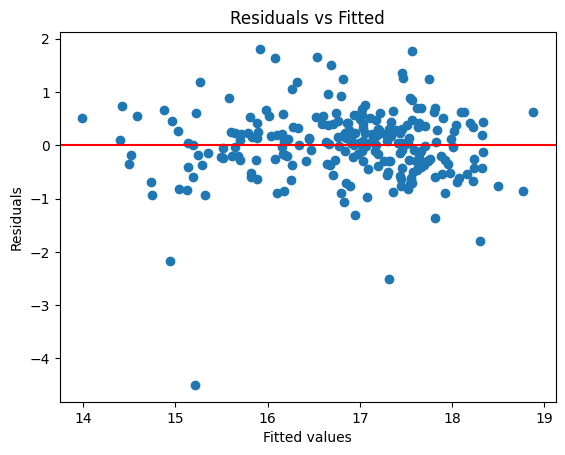

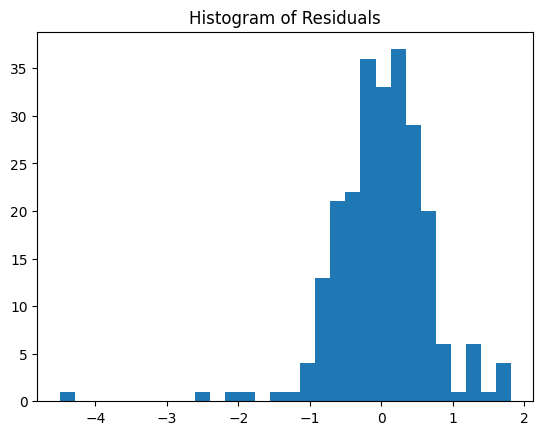

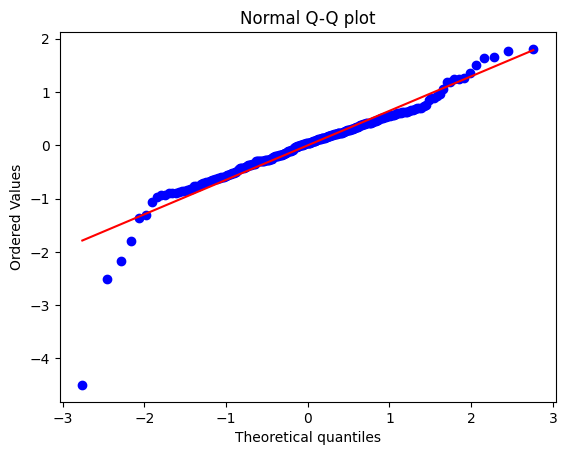

In [30]:
import matplotlib.pyplot as plt
from scipy import stats

residuals = y - predictions
fitted_values = predictions

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()


### Lasso / Ridge

In [31]:
from sklearn.linear_model import Lasso

model = Lasso()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

MAPE: 0.0547 (+/- 0.0177)


In [33]:
from sklearn.linear_model import Ridge

model = Ridge()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

MAPE: 0.0393 (+/- 0.0142)


### Tree-based

In [34]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=23,min_samples_leaf=10,min_samples_split=7,n_estimators=250)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

MAPE: 0.0377 (+/- 0.0139)


In [35]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(learning_rate=0.05)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

MAPE: 0.0385 (+/- 0.0119)


In [36]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(learning_rate=0.05, max_depth=6)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4033
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 55
[LightGBM] [Info] Start training from score 16.845572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

### SVR

In [37]:
from sklearn.svm import SVR

model = SVR()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

MAPE: 0.0350 (+/- 0.0128)


### Ensemble

In [38]:
from sklearn.ensemble import StackingRegressor

base_models = [
    ('ridge', Ridge()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('lgbm', LGBMRegressor(learning_rate=0.05, max_depth=6, verbose=1)),
    ('svr', SVR())
]

# Meta-learner
meta_learner = LinearRegression()

# Stacking Regressor
model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1
)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")


MAPE: 0.0345 (+/- 0.0145)


## Word Embeddings

In [40]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=df['script'].str.split(), vector_size=200, window=5, min_count=1, workers=4)

import numpy as np

# Function to compute the average of word vectors in a sentence
def get_sentence_vector(sentence, model):
    # Tokenize the sentence and get the corresponding word vectors
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    
    if len(word_vectors) == 0:
        # If there are no words in the vocabulary, return a zero vector
        return np.zeros(model.vector_size)
    
    # Average the word vectors
    sentence_vector = np.mean(word_vectors, axis=0)
    return sentence_vector

df['sentence_vector'] = df['script'].str.split().apply(lambda x: get_sentence_vector(x, model))


In [41]:

X = np.array(np.stack(df['sentence_vector'].values))

word_count_array = df[['word_count', 'sentiment_polarity', 
                       'unique_words','flag_california',
                       'flag_beach','flag_dubai',
                       'flag_florida', 'flag_texas',
                       'flag_la']].values
X_combined = np.hstack((X, word_count_array))  

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X_combined)

pca = PCA(n_components=.6)
X = pca.fit_transform(data_rescaled)

y = np.log1p(df['dollar_amount'])

print(X.shape)

X = np.array(X)
y = np.array(y)

(239, 4)


In [42]:
from sklearn.ensemble import StackingRegressor

base_models = [
    ('ridge', Ridge()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('lgbm', LGBMRegressor(learning_rate=0.05, max_depth=6, verbose=1)),
    ('svr', SVR())
]

# Meta-learner
meta_learner = LinearRegression()

# Stacking Regressor
model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1
)

mape = -1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"MAPE: {mape.mean():.4f} (+/- {mape.std() * 2:.4f})")

MAPE: 0.0444 (+/- 0.0131)
